In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [2]:
dataset = trn.get_dataset('3dshapes', train=None, labeled=True)
len(dataset)

Loading dataset: 3dshapes
dataroot: C:\Users\anwan\Documents\workspace\local_data
load_memory: True (by default)
train: None
labeled: True
label_type: class (by default)
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Found FID Stats


480000

In [3]:
lbls = dataset.labels.clone()
lbls.shape

torch.Size([480000, 6])

In [4]:
dataset.factor_order

['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [5]:
M = trn.Run_Manager()

Found 76 runs
Auto parsing failed with: ae_3ds_200408-021254
Auto parsing failed with: ae_3ds_200408-203033
Auto parsing failed with: ae_3ds_200409-190321
Auto parsing failed with: pvae_3ds_200409-001541
Auto parsing failed with: pvae_3ds_200409-155129
Auto parsing failed with: pvae_3ds_b16_200409-001535
Auto parsing failed with: pvae_3ds_b16_200409-155133
Auto parsing failed with: test-cmd_200421-140543
Auto parsing failed with: test-cmd_200421-141120
Auto parsing failed with: test-cmd_200428-171102
Auto parsing failed with: test-cmd_200428-171800
Auto parsing failed with: test-cmd_200429-022716
Auto parsing failed with: test-cmd_200429-022749
Auto parsing failed with: test-cmd_200429-023649
Auto parsing failed with: test-cmd_200429-023721
Auto parsing failed with: test-cmd_200429-024335
Auto parsing failed with: test-cmd_200429-163300
Auto parsing failed with: test-cmd_200429-164034
Auto parsing failed with: test-cmd_200507-021310
Auto parsing failed with: test-cmd_200507-031449
Auto

In [6]:
M.show()

  0) 3ds-ae-12b1-deep_0010-6241682-08_200414-021349
  1) 3ds-ae-12b1_0006-6241674-05_200414-020822
  2) 3ds-ae-12b1_0015-6243020-00_200414-174614
  3) 3ds-vae-b16-dislib_0000-6240594-01_200413-141958
  4) 3ds-vae-b16_0036-6247161-01_200416-005319
  5) ae_3ds_200408-021254
  6) ae_3ds_200408-203033
  7) ae_3ds_200409-190321
  8) pvae_3ds_200409-001541
  9) pvae_3ds_200409-155129
 10) pvae_3ds_b16_200409-001535
 11) pvae_3ds_b16_200409-155133
 12) vae_3ds_200408-004029
 13) vae_3ds_200408-013548
 14) vae_3ds_b16_200408-180706
 15) vae_3ds_b1_200408-180817
 16) vae_3ds_no_min_200408-024121
 17) vae_3ds_subset100k_200409-230140
 18) vae_3ds_subset100k_200409-230242
 19) vae_3ds_subset10k_200410-021855
 20) wae_3ds_200408-004028
 21) wae_3ds_200408-160525
 22) wae_3ds_200408-160719
 23) wae_3ds_200408-170412
 24) wae_3ds_200408-203019


In [7]:
M.filter(lambda r: '3ds-' in r.name)
M.show()

  0) 3ds-ae-12b1-deep_0010-6241682-08_200414-021349
  1) 3ds-ae-12b1_0006-6241674-05_200414-020822
  2) 3ds-ae-12b1_0015-6243020-00_200414-174614
  3) 3ds-vae-b16-dislib_0000-6240594-01_200413-141958
  4) 3ds-vae-b16_0036-6247161-01_200416-005319


In [8]:
M.load_into('results.pth.tar')

results.pth.tar not found in: 3ds-ae-12b1-deep_0010-6241682-08_200414-021349


In [9]:
idx = 2

In [10]:
run = M[idx]
run.latent_params = {}
run.name, run.results.keys()

('3ds-ae-12b1_0015-6243020-00_200414-174614',
 dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid']))

In [11]:
A = trn.get_config()
A.din = (3,64,64)
A.dout = (3,64,64)

model, = trn.load(run.name, get_data=None, A=A, update_config=True)
print(model)

C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1_0015-6243020-00_200414-174614\best.pth.tar
True
load successful


calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1_0015-6243020-00_200414-174614\best.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 1 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
    [4]: 64
    [5]: 64
    [6]: 64
    [7]: 64
    [8]: 64
    [9]: 64
    [10]: 64
    [11]: 64
    factors (type=list): 
    [0]: 1
  

)


In [12]:
run.results['rec_fid'], run.results['hyb_fid']

(7.102457966815535, 16.437563195856455)

In [13]:
out = run.results['out']
out.keys()

odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])

In [14]:
ckpt = torch.load(os.path.join(run.path, 'checkpoint_100000.pth.tar'))
ckpt.keys()

dict_keys(['model_str', 'model_state', 'records', 'epoch_seed'])

In [15]:
mstate = ckpt['model_state']
mstate.keys()

dict_keys(['model', 'optim'])

In [16]:
# bad = ["dec.layers.2.deconv.1.weight", "dec.layers.2.deconv.1.bias", "dec.layers.5.deconv.1.weight", "dec.layers.5.deconv.1.bias", "dec.layers.8.deconv.1.weight", "dec.layers.8.deconv.1.bias", "dec.layers.10.deconv.1.weight", "dec.layers.10.deconv.1.bias"]
bad = ["dec.layers.2.deconv.1.weight", "dec.layers.2.deconv.1.bias", "dec.layers.5.deconv.1.weight", "dec.layers.5.deconv.1.bias", "dec.layers.8.deconv.1.weight", "dec.layers.8.deconv.1.bias", "dec.layers.10.deconv.1.weight", "dec.layers.10.deconv.1.bias"]

fix = []
for bname in bad:
    f = bname.split('.')
    f = f[:4] + f[5:]
    f = '.'.join(f)
    fix.append(f)

# bad = ["dec.deconv.0.deconv.1.weight", "dec.deconv.0.deconv.1.bias", "dec.deconv.1.deconv.1.weight", "dec.deconv.1.deconv.1.bias", "dec.deconv.2.deconv.1.weight", "dec.deconv.2.deconv.1.bias", "dec.deconv.3.deconv.1.weight", "dec.deconv.3.deconv.1.bias", "dec.deconv.4.deconv.1.weight", "dec.deconv.4.deconv.1.bias"]
# fix = ["dec.deconv.0.deconv.weight", "dec.deconv.0.deconv.bias", "dec.deconv.1.deconv.weight", "dec.deconv.1.deconv.bias", "dec.deconv.2.deconv.weight", "dec.deconv.2.deconv.bias", "dec.deconv.3.deconv.weight", "dec.deconv.3.deconv.bias", "dec.deconv.4.deconv.weight", "dec.deconv.4.deconv.bias"]


In [17]:


for bname, fname in zip(bad, fix):
    if bname in mstate['model']['parameters']:
        mstate['model']['parameters'][fname] = mstate['model']['parameters'][bname]
        del mstate['model']['parameters'][bname]
        print(f'replaced {bname} with {fname}')

replaced dec.layers.2.deconv.1.weight with dec.layers.2.deconv.weight
replaced dec.layers.2.deconv.1.bias with dec.layers.2.deconv.bias
replaced dec.layers.5.deconv.1.weight with dec.layers.5.deconv.weight
replaced dec.layers.5.deconv.1.bias with dec.layers.5.deconv.bias
replaced dec.layers.8.deconv.1.weight with dec.layers.8.deconv.weight
replaced dec.layers.8.deconv.1.bias with dec.layers.8.deconv.bias
replaced dec.layers.10.deconv.1.weight with dec.layers.10.deconv.weight
replaced dec.layers.10.deconv.1.bias with dec.layers.10.deconv.bias


In [18]:
model.load_state_dict(mstate)

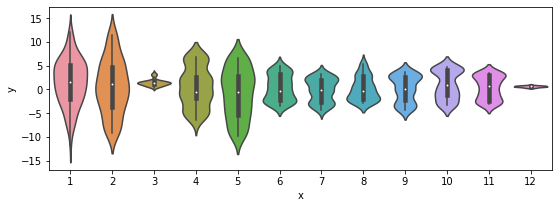

In [21]:
saved_Q = out['latent']
if isinstance(saved_Q, distrib.Normal):
    saved_Q = saved_Q.mean
saved_Q = saved_Q.cpu()
fig, ax = util.plot_distribs(saved_Q, figsize=(9, 3))
pass

In [20]:
# with torch.no_grad():
#     g = model.generate(64)
# util.show_imgs(g)
# pass

In [22]:
target = 'floor_hue'
target = 'wall_hue'
target = 'object_hue'

In [23]:
idx

2

In [24]:
# based on manual check
color_dims = [
    {},
    {'object_hue': [6,7], 'wall_hue':[8,9], 'floor_hue':[10,11]},
    {'object_hue': [5,6], 'wall_hue':[9,10], 'floor_hue':[7,8]},
    {},
    {'object_hue': [3,5], 'wall_hue':[2,10], 'floor_hue':[0,9]},
]
lbl_dims = {'floor_hue':0, 'wall_hue':1, 'object_hue':2}
ldim = lbl_dims[target]
dims = color_dims[idx][target]

In [25]:
H = 16
W = 16

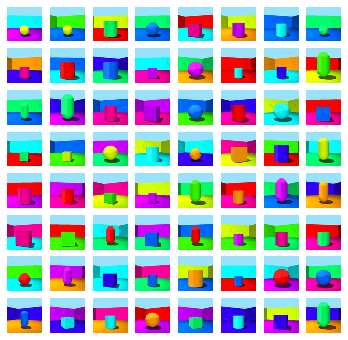

In [26]:
util.show_imgs(out['original'][:64])
pass

In [27]:
np.mgrid[1:0:H*-1j]

array([1.        , 0.93333333, 0.86666667, 0.8       , 0.73333333, 0.66666667, 0.6       , 0.53333333, 0.46666667,
       0.4       , 0.33333333, 0.26666667, 0.2       , 0.13333333, 0.06666667, 0.        ])

In [76]:
Q = saved_Q
deltas = torch.from_numpy(np.mgrid[1:0:H*-1j,0:1:W*1j]).float()
mn, mx = Q[:,dims].min(0)[0], Q[:,dims].max(0)[0]
print(mn, mx)
mn, mx = mn.view(-1,1,1), mx.view(-1,1,1)
deltas = deltas * (mx-mn) + mn
deltas = deltas.permute(1,2,0).view(-1,2)
# deltas.shape
# vecs = Q[23].unsqueeze(0).expand(H*W,-1).clone()
vecs = Q[12].unsqueeze(0).expand(H*W,-1).clone()
vecs[:,dims] = deltas
vecs = vecs.view(H,W,-1).permute(1,0,2).contiguous().view(H*W,-1)
vecs.shape

tensor([-3.5423, -4.3568]) tensor([4.8418, 3.3070])


torch.Size([256, 12])

In [77]:
vecs = torch.from_numpy(vecs.numpy()[::-1].copy())

In [78]:
with torch.no_grad():
    raw = model.decode(vecs.to(model.device)).cpu()
raw.shape

torch.Size([256, 3, 64, 64])

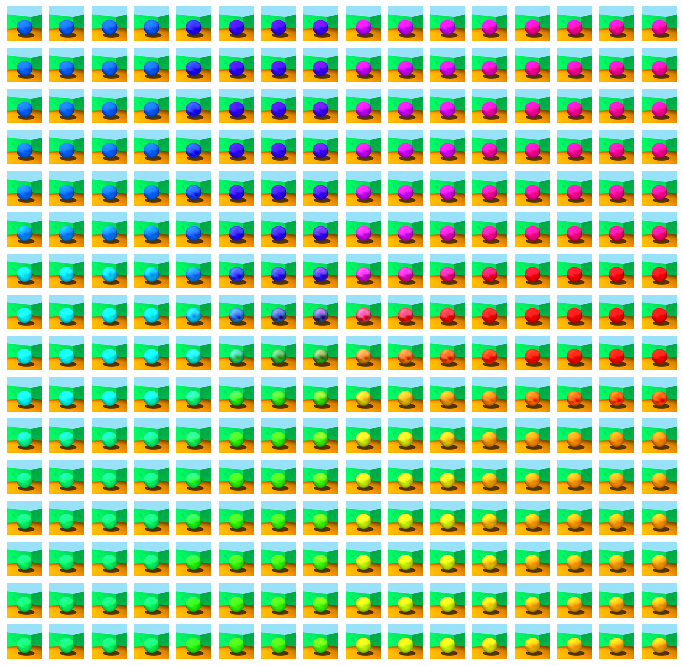

In [79]:
util.show_imgs(raw, H=H,W=W, figsize=(12,12))
pass

In [80]:
raw.shape

torch.Size([256, 3, 64, 64])

In [81]:
mids = raw[:,:,40:44, 30:34]
mids.shape

torch.Size([256, 3, 4, 4])

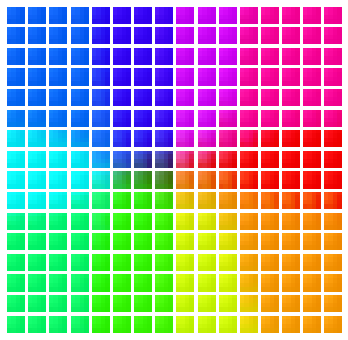

In [82]:
util.show_imgs(mids)
pass

In [83]:
clrs = mids.mean(-1).mean(-1)
clrs.shape

torch.Size([256, 3])

In [84]:
tmids = X[10:20,:,40:44,30:34]
tmids.shape

torch.Size([10, 3, 4, 4])

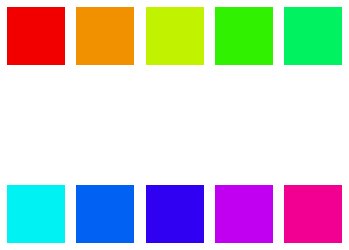

In [85]:
util.show_imgs(tmids)
pass

In [86]:
tclrs = tmids.mean(-1).mean(-1)
tclrs.shape

torch.Size([10, 3])

In [87]:
cat_styles = {'gen':{'color':'k', 'alpha':0.3, 'lw':1}, 
              
#                         'train':{'color':'k', 'lw':4, 'alpha':0.8},
                    }

cats = []
# cats = cats +['train']*len(tclrs)

for i, c in enumerate(tclrs):
    c = tuple(c.cpu().numpy())
    cat = f'{i}'
    cat_styles[cat] = {'color':c, 'lw':5, 'alpha': 1}
    cats.append(cat)

cats = cats + ['gen']*len(clrs)

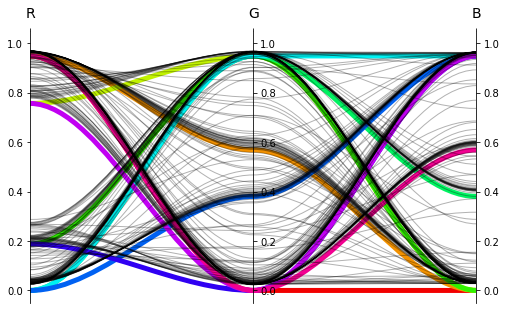

In [69]:
util.plot_parallel_coords(torch.cat([tclrs,clrs]), dim_names=['R','G','B'], 
                     categories=cats, include_legend=False,
                     mins=torch.zeros(3), maxs=torch.ones(3),
                    cat_styles=cat_styles)
pass

In [70]:
raw.shape

torch.Size([256, 3, 64, 64])

In [95]:
vecs.shape

torch.Size([256, 12])

In [100]:
with torch.no_grad():
    rimg, rq = model(raw.to(model.device), ret_q=True)
    if isinstance(rq, distrib.Normal):
        rq = rq.mean
    rimg, rq = rimg.cpu(), rq.cpu()
    rd = rq[:,dims]
rimg.shape, rq.shape

(torch.Size([256, 3, 64, 64]), torch.Size([256, 12]))

In [101]:
# fix order
rd = torch.from_numpy(rd.numpy()[::-1].copy())
rd = rd.view(H,W,-1).permute(1,0,2).contiguous().view(H*W,-1)

In [102]:

rd.shape, deltas.shape

(torch.Size([256, 2]), torch.Size([256, 2]))

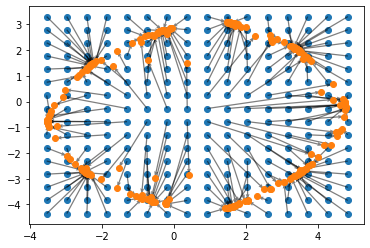

In [103]:
plt.figure()
plt.scatter(*deltas.t())
dr = rd - deltas
# sel = slice(0,-1)
plt.quiver(*deltas.t(), *dr.t(),angles='xy', scale_units='xy', scale=1, alpha=0.5)# scale=.01)
plt.scatter(*rd.t())
pass

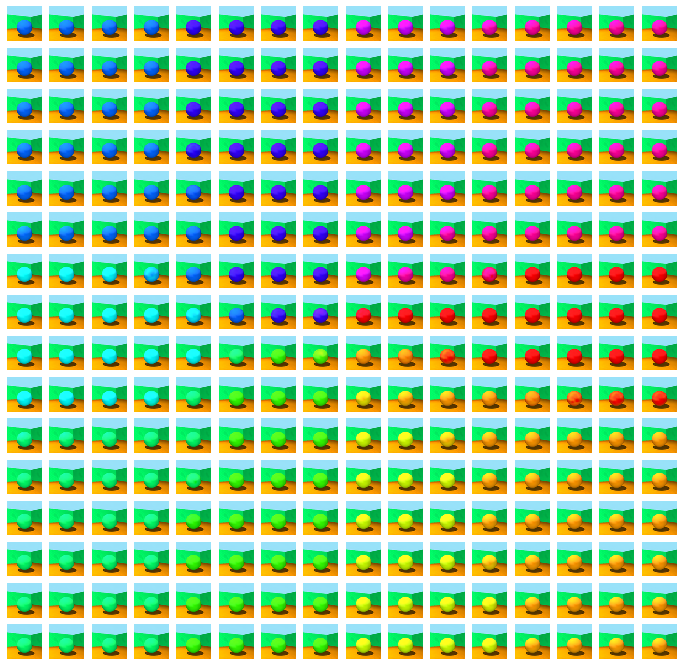

In [104]:
util.show_imgs(rimg, H=H,W=W, figsize=(12,12))
pass

In [105]:
raw.shape

torch.Size([256, 3, 64, 64])

In [106]:
rmids = rimg[:,:,40:44, 30:34]
rmids.shape

torch.Size([256, 3, 4, 4])

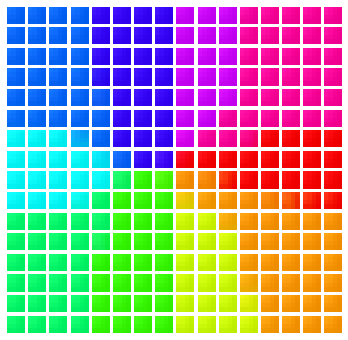

In [107]:
util.show_imgs(rmids)
pass

In [45]:
N = 10
D = dataset.factor_sizes[ldim]

In [39]:
torch.manual_seed(3)
picks = torch.randint(np.product(dataset.factor_sizes).item() // (10*10*10), size=(N,))
picks

tensor([106, 248, 217, 387, 280, 360,   0, 245,  61,  19])

In [40]:
dataset.factor_sizes

[10, 10, 10, 8, 4, 15]

In [41]:
dens = torch.from_numpy(np.cumprod([1] + dataset.factor_sizes[:0:-1],0)[::-1].copy()).long()
dens

tensor([48000,  4800,   480,    60,    15,     1])

In [42]:
ldim

2

In [43]:
fixed = torch.stack([picks//(15*4)%8, picks//(15)%4, picks%15],1).unsqueeze(1).expand(N,D,-1)
var = torch.randint(10,size=(N,3)).unsqueeze(1).expand(N,D,-1).contiguous()
delta = torch.arange(D).unsqueeze(0).expand(N,-1)
var.shape, fixed.shape, delta.shape

var[...,ldim] = delta

cls = torch.cat([var, fixed], -1).view(N*D,-1)
cls.shape

torch.Size([100, 6])

In [46]:
inds = cls @ dens.view(-1)
inds

tensor([196906, 197386, 197866, 198346, 198826, 199306, 199786, 200266, 200746,
        201226, 461048, 461528, 462008, 462488, 462968, 463448, 463928, 464408,
        464888, 465368, 259417, 259897, 260377, 260857, 261337, 261817, 262297,
        262777, 263257, 263737, 221187, 221667, 222147, 222627, 223107, 223587,
        224067, 224547, 225027, 225507,  77080,  77560,  78040,  78520,  79000,
         79480,  79960,  80440,  80920,  81400, 417960, 418440, 418920, 419400,
        419880, 420360, 420840, 421320, 421800, 422280, 192000, 192480, 192960,
        193440, 193920, 194400, 194880, 195360, 195840, 196320,  67445,  67925,
         68405,  68885,  69365,  69845,  70325,  70805,  71285,  71765, 441661,
        442141, 442621, 443101, 443581, 444061, 444541, 445021, 445501, 445981,
          9619,  10099,  10579,  11059,  11539,  12019,  12499,  12979,  13459,
         13939])

In [47]:
X, Y = dataset[inds]
X.shape, Y.shape

(torch.Size([100, 3, 64, 64]), torch.Size([100, 6]))

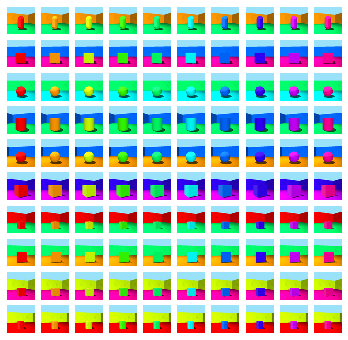

In [48]:
util.show_imgs(X)
pass

In [88]:
x = X.clone()

In [89]:
bidx = torch.randperm(len(dataset))[:10000].view(-1,100)
colors = []
for b in bidx:
    X = dataset[b][0]
    with torch.no_grad():
        c = model.encode(x.to(model.device)).cpu()
    colors.append(c[:,dims])
colors = torch.cat(colors)
colors.shape

torch.Size([10000, 2])

In [90]:
bias = colors.mean(0)
r = colors.norm(dim=1).mean()
t = torch.linspace(0,2*np.pi, 1000)
circx = r*torch.cos(t) + bias[0]
circy = r*torch.sin(t) + bias[1]
if target not in run.latent_params:
    run.latent_params[target] = r, bias
run.latent_params.keys()

dict_keys(['object_hue'])

In [91]:
with torch.no_grad():
    qcol = model.encode(x.to(model.device)).cpu()
qcol = qcol.view(N,D,-1)[...,dims]
qcol.shape

torch.Size([10, 10, 2])

In [92]:
plt.text?

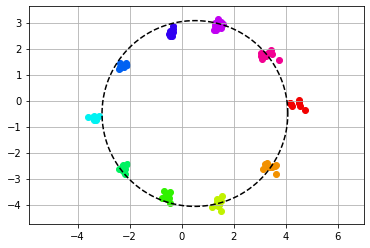

In [94]:
plt.figure()
# plt.scatter(*colors.t(), marker='.', color='k')
plt.plot(circx, circy, color='k', ls='--')
for i,q in enumerate(qcol.permute(1,0,2)):
#     v = q.mean(0)
#     v = 1.1*(v-bias) + bias
#     plt.text(*v,str(i+1))
    plt.scatter(*q.t(),color=tclrs[i])
#     plt.plot(*q[0].t(),marker='o', color='C{}'.format(i%10))
#     plt.plot(*q.t(), color='C{}'.format(i%10))
# plt.arrow(0,0,*bias,ls='--', color='r', head_width=.2)
plt.axis('equal')
plt.grid()

In [237]:
# from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
# imagebox = OffsetImage(arr_lena, zoom=0.2)
# ab = AnnotationBbox(imagebox, (0.4, 0.6))
# ax.add_artist(ab)

In [260]:
run.latent_params

{'floor_hue': (tensor(3.7934), tensor([ 0.5682, -0.2487])),
 'wall_hue': (tensor(3.8383), tensor([1.0232, 0.1928])),
 'object_hue': (tensor(3.6091), tensor([ 0.5342, -0.5389]))}

In [266]:
extra_dims = {
    'orientation': 1,
    'shape': 3,
    'size': 4,
}
edims = [1,3,4]

# for e,d in extra_dims.items():
#     run.latent_params[e] = Q.min(0)[0][d], Q.max(0)[0][d]
run.latent_params

{'floor_hue': (tensor(3.7934), tensor([ 0.5682, -0.2487])),
 'wall_hue': (tensor(3.8383), tensor([1.0232, 0.1928])),
 'object_hue': (tensor(3.6091), tensor([ 0.5342, -0.5389])),
 'orientation': (tensor(-9.1822), tensor(11.5384)),
 'shape': (tensor(-6.5202), tensor(6.8098)),
 'size': (tensor(-9.7521), tensor(6.7033))}

In [267]:
mns, mxs = Q.min(0)[0][edims], Q.max(0)[0][edims]
mns, mxs

(tensor([-9.1822, -6.5202, -9.7521]), tensor([11.5384,  6.8098,  6.7033]))

In [289]:
G = 64

In [290]:
cdims = color_dims[idx]
cdims

{'object_hue': [5, 6], 'wall_hue': [9, 10], 'floor_hue': [7, 8]}

In [299]:
S = model._q.cpu()
S.shape

torch.Size([128, 12])

In [300]:
# structured hybridization sampling (respecting periodicity of colors)
cpicks = [torch.randint(S.size(0), size=(G,)) for _ in range(len(cdims))]
epicks = [torch.randint(S.size(0), size=(G,)) for _ in range(len(extra_dims))]
len(cpicks), len(epicks)

(3, 3)

In [301]:
H = model.hybridize(S)[:G]
for dms, cp in zip(cdims.values(), cpicks):
    H[:,dms] = S[cp][:,dms]
for dm, ep in zip(extra_dims.values(), epicks):
    H[:,dm] = S[ep][:,dm]
H.shape

torch.Size([64, 12])

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


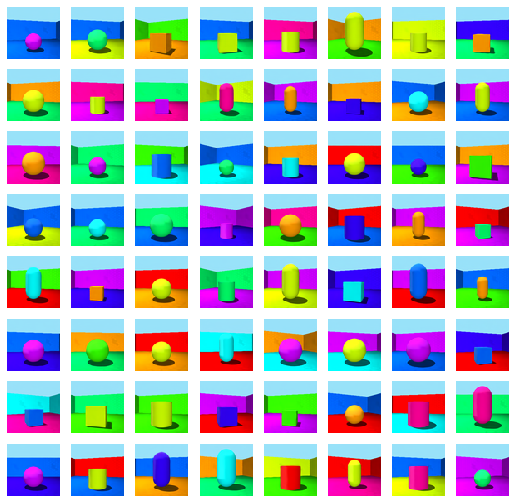

In [302]:
with torch.no_grad():
    gen = model.decode(H.to(model.device)).cpu()
util.show_imgs(gen, figsize=(9,9))
pass

In [303]:
# structured continuous sampling (based on MLE of periodic dims, and uniformly random for others)

H = torch.rand(G, S.size(-1))
mns, mxs = S.min(0)[0].unsqueeze(0), S.max(0)[0].unsqueeze(0)
H = (mxs-mns)*H + mns

for cname, dms in cdims.items():
    r, b = run.latent_params[cname]
    
    t = torch.rand(G)*2*np.pi
    
    H[:,dims] = torch.stack([r*torch.cos(t), r*torch.sin(t)], -1) + b.unsqueeze(0)

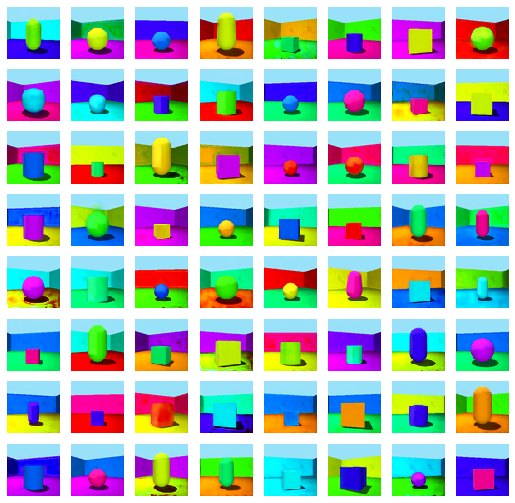

In [305]:
with torch.no_grad():
    sgen = model.decode(H.to(model.device)).cpu()
util.show_imgs(sgen,figsize=(9,9))
pass

In [108]:
j = '/home/fleeb/jobs/job0047_200421-141428/job_4.sh'

In [110]:
*other, jdir, jexe = j.split('/')
jdir, jexe

('job0047_200421-141428', 'job_4.sh')

In [113]:
num, date = jdir.split('_')
num = int(num[3:])
num, date

(47, '200421-141428')

In [ ]:
def parse_jobpath(path):
    

In [114]:
h = 'slot1_1@g034.internal.cluster.is.localnet'

In [119]:
s, g = h.split('.')[0].split('@')
s = s.split('_')[-1]
f'{s}{g}'

'1g034'

In [120]:
from tabulate import tabulate

In [121]:
tabulate

<function tabulate.tabulate(tabular_data, headers=(), tablefmt='simple', floatfmt='g', numalign='decimal', stralign='left', missingval='', showindex='default', disable_numparse=False, colalign=None)>

In [127]:
table = [["Sun",696000,1989100000],["Earth",6371,5973.6],
          ["Moon",1737,73.5],["Mars",3390,641.85]]
print(tabulate(table, floatfmt='.10g'))

-----  ------  -------------
Sun    696000  1989100000
Earth    6371        5973.6
Moon     1737          73.5
Mars     3390         641.85
-----  ------  -------------


In [128]:
l = [1, 2, 3]
for x in l:
    if x % 2 == 0:
        l.remove(x)

In [129]:
l

[1, 3]